# Chapter 17: Analyzing Time Series in the Frequency Domain

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = [14, 4]  
plt.style.use('grayscale')

folder = Path('../../datasets/Ch17/')
file = folder.joinpath('AEP_hourly.csv')

df = pd.read_csv(file, index_col='Datetime', parse_dates=True)

df.sort_index(inplace=True)
df = df.resample('h').last()
df.columns = ['y']
df.ffill(inplace=True)

print(f"Final dataset shape: {df.shape}")
print(f"Data frequency: {df.index.freq}")
print(f"Any missing values: {df.isnull().any().any()}")

Final dataset shape: (121296, 1)
Data frequency: <Hour>
Any missing values: False


<Axes: xlabel='Datetime'>

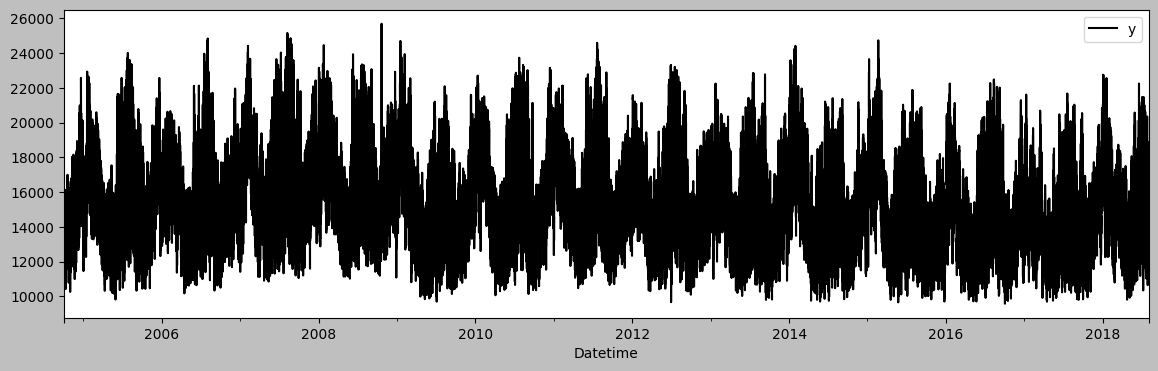

In [2]:
df.plot()

# Recipe 1: Visualizing Cycles with the Periodogram
* **Periodogram**: Estimates the power spectral density (PSD) of a signal, showing how the power of a time series is distributed over frequency. It is typically smoother and focuses on the strength of periodic components.
* **FFT**: Decomposes the signal into its frequency components, showing the magnitude (and phase) of each frequency present. The FFT spectrum can reveal all frequencies, but may be less smooth and more sensitive to noise.

In [3]:
from scipy.signal import periodogram, find_peaks

# Prepare the data (no changes here)
y = df['y'].astype(float)
fs = 1.0 # Sampling frequency is 1 sample per hour

# 'constant' detrending is the same as subtracting the mean.
freqs, power = periodogram(
                     y, 
                     fs=fs, 
                     window='hann', 
                     detrend='constant', 
                     scaling='spectrum', 
                     return_onesided=True
                     )

# Convert frequency to period, handling potential zero frequency
# period_hours = np.where(freqs > 0, 1 / freqs, np.inf)
valid = freqs > 0
f_pos = freqs[valid]
P_pos = power[valid]
period_hours = 1.0 / f_pos

# Use a prominenc threshold to find significant peaks
peaks, props = find_peaks(
                P_pos, 
                prominence=np.max(P_pos) * 0.20, 
                distance=2
                ) 

# Create a DataFrame for easy sorting and inspection
spec_df = pd.DataFrame({
    'period_hours': period_hours[peaks],
    'power': P_pos[peaks],
    'prominence': props['prominences']
}).sort_values('power', ascending=False)

# Sort by power to find the most prominent cycles
print("Most prominent cycles found:")
top_peaks = spec_df.head(5).copy()
top_peaks['days'] = top_peaks['period_hours'] / 24.0
print(top_peaks)

Most prominent cycles found:
   period_hours         power    prominence   days
2          24.0  1.418589e+06  1.418589e+06    1.0
0        4332.0  1.257695e+06  1.256908e+06  180.5
1         168.0  4.092836e+05  4.092819e+05    7.0
3          12.0  3.071967e+05  3.071967e+05    0.5


In [4]:
props

{'prominences': array([1256907.50929735,  409281.90123081, 1418588.80827762,
         307196.71098812]),
 'left_bases': array([  21,  646, 3599, 8378]),
 'right_bases': array([ 3599,  3599, 45205, 45205])}

In [5]:
def get_period_label(period_hours):
    """Assigns a descriptive label to a period in hours."""
    if np.isclose(period_hours, 24, atol=1):
        return 'Daily (24h)'
    if np.isclose(period_hours, 12, atol=1):
        return 'Semi-daily (12h)'
    if np.isclose(period_hours, 168, atol=5):
        return 'Weekly (168h)'
    if np.isclose(period_hours, 4380, atol=360): # 4380 is avg hours in 6 months
        return 'Semi-annual (~6mo)'
    return f'{period_hours:.0f}h' # Default label for other peaks

In [6]:
top_peaks['labels'] = top_peaks['period_hours'].apply(get_period_label)
top_peaks

period_hours         power    prominence   days              labels
2          24.0  1.418589e+06  1.418589e+06    1.0         Daily (24h)
0        4332.0  1.257695e+06  1.256908e+06  180.5  Semi-annual (~6mo)
1         168.0  4.092836e+05  4.092819e+05    7.0       Weekly (168h)
3          12.0  3.071967e+05  3.071967e+05    0.5    Semi-daily (12h)

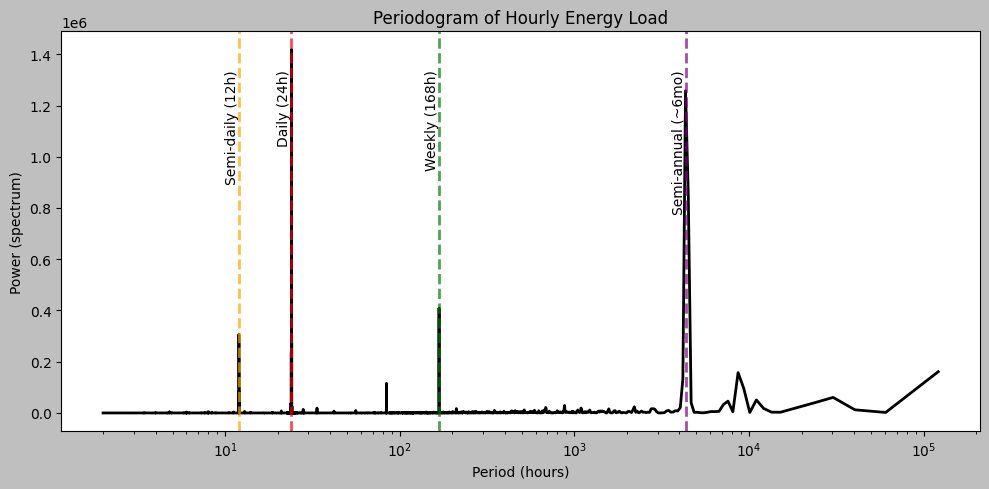

In [7]:
color_map = {
    'Daily (24h)': 'red',
    'Weekly (168h)': 'green',
    'Semi-annual (~6mo)': 'purple',
    'Semi-daily (12h)': 'orange'
}

top_peaks['color'] = top_peaks['labels'].map(color_map)

plt.figure(figsize=(10,5))
plt.plot(period_hours, P_pos, lw=2)
plt.xscale('log')
plt.xlabel('Period (hours)')
plt.ylabel('Power (spectrum)')
plt.title('Periodogram of Hourly Energy Load')

for index, row in top_peaks.iterrows():
    # Draw the vertical line
    plt.axvline(
        x=row['period_hours'],
        color=row['color'],
        ls='--',
        linewidth=2,
        alpha=0.7
    )
    # Add the text label
    plt.text(
        x=row['period_hours'],
        y=plt.ylim()[1] * 0.9,
        s=row['labels'],
        rotation=90,
        va='top',
        ha='right',
        fontsize=10
    )

plt.tight_layout()
plt.show()

## How it works

In [8]:
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.statespace.sarimax import SARIMAX

day = 24
week=168
semi_annual = 4332

fourier_daily  = Fourier(period=day, order=4)
fourier_weekly = Fourier(period=week, order=6) 
fourier_semi_annual = Fourier(period=semi_annual, order=8)  


idx = df.index 
X_list = [
    fourier_daily.in_sample(idx),
    fourier_weekly.in_sample(idx),
    fourier_semi_annual.in_sample(idx),
]

X = pd.concat(X_list, axis=1)

train = df.iloc[:-week]
test = df.iloc[-week:]
exog_train = X.iloc[:-week]
exog_test = X.iloc[-week:]

mod = SARIMAX(
    train['y'], 
    exog=exog_train,
    order=(1, 0, 1)
)
res = mod.fit(disp=False)

In [9]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               121128
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -857230.653
Date:                Fri, 05 Sep 2025   AIC                        1714539.307
Time:                        15:52:18   BIC                        1714917.786
Sample:                    10-01-2004   HQIC                       1714653.185
                         - 07-27-2018                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sin(1,24)   -1183.9911      8.843   -133.897      0.000   -1201.322   -1166.660
cos(1,24)   -1200.5150      7.508   -159.892      0.000   -1215.231   -1185.799
sin(2,24)    -734.7211      3.720   -197.524    

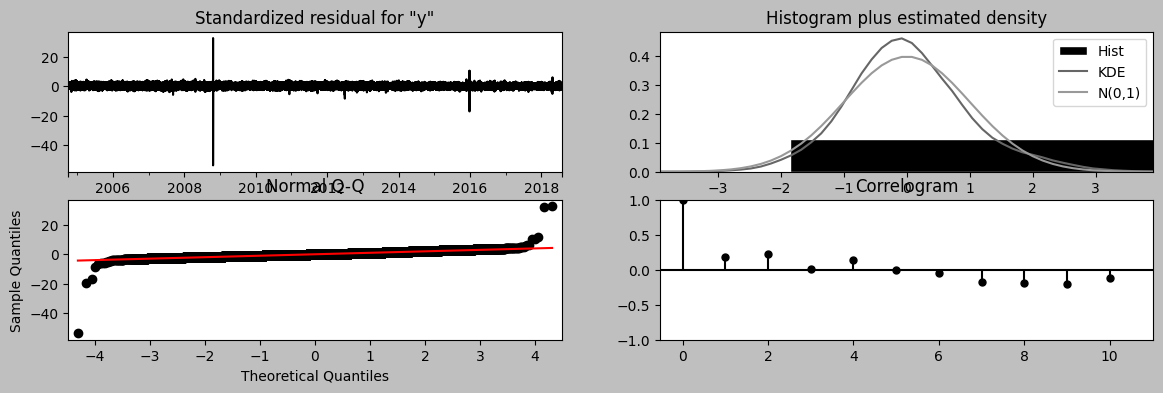

In [10]:
res.plot_diagnostics()
plt.show()

In [11]:
fc = res.get_forecast(steps=len(test), 
                      exog=exog_test)

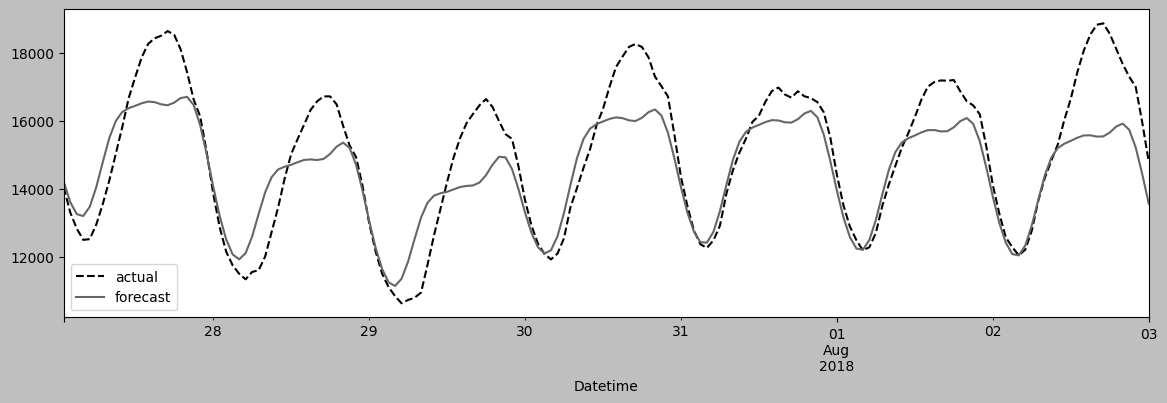

In [12]:
test.plot(style='--')
fc.predicted_mean.plot()
plt.legend(['actual', 'forecast'])
plt.show()

In [13]:
from statsmodels.tools.eval_measures import rmse, meanabs as mae

yhat = fc.predicted_mean


sarimax_mae = mae(test['y'], yhat)
sarimax_rmse = rmse(test['y'], yhat)
print(f'SARIMAX MAE: {sarimax_mae}')
print(f'SARIMAX RMSE: {sarimax_rmse}')

SARIMAX MAE: 875.3165259165502
SARIMAX RMSE: 1142.8519150203192


## There's more

In [14]:
from scipy.signal import welch, find_peaks

# Assume y is a 1-D NumPy array of hourly values
fs = 1.0  # samples per hour
nperseg = 24 * 30

# Welch (use same preprocessing concepts as before)
f_welch, power = welch(
    y,
    fs=fs,
    window='hann',
    nperseg=nperseg,
    noverlap=nperseg // 2,
    detrend='constant',
    return_onesided=True,
    scaling='spectrum',  
    average='mean'
)

# Positive frequencies only
valid = f_welch > 0
f_w = f_welch[valid]
P_w = power[valid]
period_w = 1.0 / f_w

# Peak picking in PSD (frequency domain)
# Start with 10% of max prominence and a small distance; tune per dataset
peaks, props = find_peaks(
    P_w,
    prominence=np.max(P_w) * 0.10,
    distance=2
)

# Build table of detected cycles
spec_w = pd.DataFrame({
    'frequency_hz': f_w[peaks],
    'period_hours': period_w[peaks],
    'power': P_w[peaks],
    'prominence': props['prominences']
}).sort_values('power', ascending=False)

print("Welch: most prominent cycles")
top_w = spec_w.head(5).copy()
top_w['days'] = top_w['period_hours'] / 24.0
print(top_w)


Welch: most prominent cycles
   frequency_hz  period_hours         power    prominence  days
1      0.041667          24.0  2.047082e+06  2.040968e+06   1.0
0      0.005556         180.0  5.228443e+05  2.419046e+05   7.5
2      0.083333          12.0  3.678194e+05  3.671850e+05   0.5


In [15]:
top_w['labels'] = top_w['period_hours'].apply(get_period_label)

top_w['color'] = top_w['labels'].map(color_map).fillna('black')

In [16]:
top_w

frequency_hz  period_hours         power    prominence  days  \
1      0.041667          24.0  2.047082e+06  2.040968e+06   1.0   
0      0.005556         180.0  5.228443e+05  2.419046e+05   7.5   
2      0.083333          12.0  3.678194e+05  3.671850e+05   0.5   

             labels   color  
1       Daily (24h)     red  
0              180h   black  
2  Semi-daily (12h)  orange

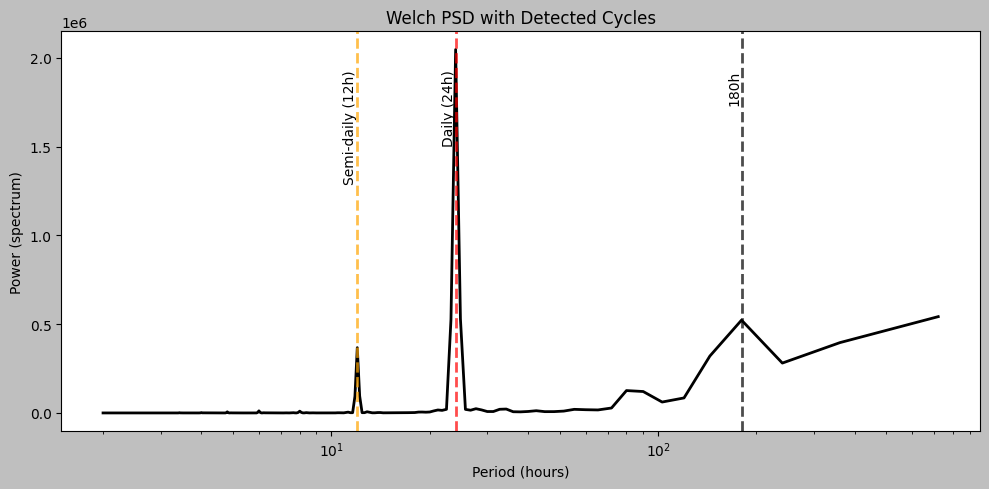

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(period_w, P_w, lw=2)
plt.xscale('log')
plt.xlabel('Period (hours)')
plt.ylabel('Power (spectrum)')
plt.title('Welch PSD with Detected Cycles')

# Annotate detected peaks automatically
for index, row in top_w.iterrows():
    # Draw the vertical line
    plt.axvline(
        x=row['period_hours'],
        color=row['color'],
        ls='--',
        linewidth=2,
        alpha=0.7
    )
    # Add the text label
    plt.text(
        x=row['period_hours'],
        y=plt.ylim()[1] * 0.9,
        s=row['labels'],
        rotation=90,
        va='top',
        ha='right',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# Recipe 2: Using Darts

In [18]:
from darts.models import FFT
from darts import TimeSeries
from darts.metrics import mae, rmse

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
darts_df = df.reset_index().copy()

ts = TimeSeries.from_dataframe(darts_df, 
                               time_col='Datetime', 
                               value_cols='y', 
                               freq='h')

In [20]:
week=168

d_train = ts[:-week]
d_test = ts[-week:]


In [21]:
print(d_train.start_time(), d_train.end_time())

2004-10-01 01:00:00 2018-07-27 00:00:00


In [22]:
fft_model = FFT(required_matches=None, 
                nr_freqs_to_keep=20, 
                trend='poly', 
                trend_poly_degree=3)

fft_model.fit(d_train)

No matching timestamp could be found, returning original TimeSeries.


FFT(nr_freqs_to_keep=20, required_matches=None, trend=poly, trend_poly_degree=3)

In [23]:
fft_pred = fft_model.predict(len(d_test))

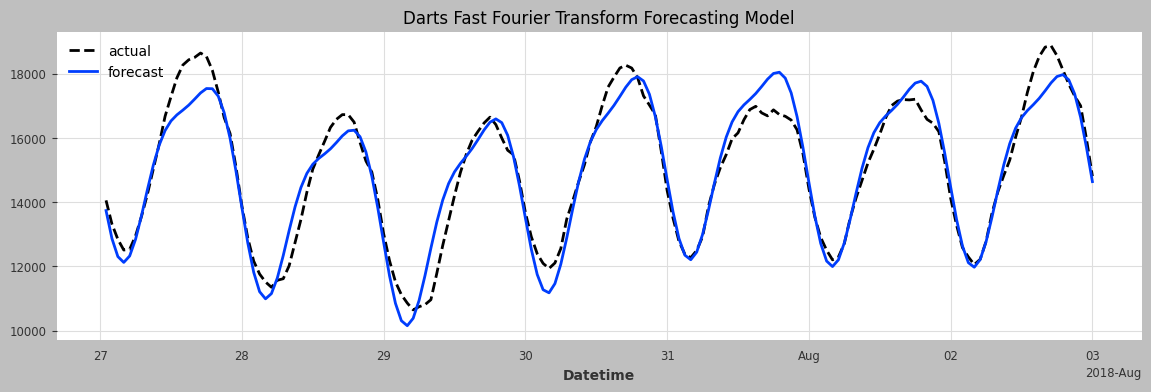

In [24]:
d_test.plot(label="actual", ls='--')
fft_pred.plot(label='forecast')
plt.title('Darts Fast Fourier Transform Forecasting Model')
plt.show()

In [25]:
print("Darts FFT MAE:", mae(fft_pred, d_test))
print("Darts FFT RMSE:", rmse(fft_pred, d_test))

Darts FFT MAE: 442.4184797364066
Darts FFT RMSE: 588.4922154503801


## There's more

In [26]:
!uv pip install statsforecast

Using Python 3.12.10 environment at: /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2
Audited 1 package in 20ms


In [27]:
from darts.models import AutoETS

In [28]:
ets_model = AutoETS()
ets_model.fit(d_train)
ets_pred = ets_model.predict(len(d_test))

print("AutoETS MAE:", mae(ets_pred, d_test))
print("AutoETS RMSE:", rmse(ets_pred, d_test))


AutoETS MAE: 1870.717835048086
AutoETS RMSE: 2170.773033209197


In [29]:
d_test.to_dataframe().index

DatetimeIndex(['2018-07-27 01:00:00', '2018-07-27 02:00:00',
               '2018-07-27 03:00:00', '2018-07-27 04:00:00',
               '2018-07-27 05:00:00', '2018-07-27 06:00:00',
               '2018-07-27 07:00:00', '2018-07-27 08:00:00',
               '2018-07-27 09:00:00', '2018-07-27 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=168, freq='h')

In [30]:
from statsmodels.tsa.deterministic import Fourier

day = 24
week=168
semi_annual = 4332
forecast_horizon=168

fourier_daily  = Fourier(period=day, order=4)
fourier_weekly = Fourier(period=week, order=6) 
fourier_semi_annual = Fourier(period=semi_annual, order=8)  


idx = df.index 
X_list = [
    fourier_daily.in_sample(idx),
    fourier_weekly.in_sample(idx),
    fourier_semi_annual.in_sample(idx)
]

X = pd.concat(X_list, axis=1)

ts_ft = TimeSeries.from_dataframe(X.reset_index(), 
                               time_col='Datetime', 
                               value_cols=X.columns.tolist(), 
                               freq='h')

ft_cov_train = ts_ft[:-forecast_horizon]
ft_cov_test = ts_ft[-forecast_horizon:]

ft_ets_model = AutoETS()

ft_ets_model.fit(d_train, future_covariates=ft_cov_train)
ft_ets_pred = ft_ets_model.predict(len(d_test), future_covariates=ts_ft)
print("AutoETS with Fourier Covariates MAE:", mae(ft_ets_pred, d_test))
print("AutoETS with Fourier Covariates RMSE:", rmse(ft_ets_pred, d_test))

AutoETS with Fourier Covariates MAE: 891.1680381441104
AutoETS with Fourier Covariates RMSE: 1058.6425007597963


# Recipe 3: Boosting ML Models with Signal Features

In [31]:
!uv pip install "lightgbm[scikit-learn]"

Using Python 3.12.10 environment at: /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2
Audited 1 package in 3ms


In [32]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from lightgbm import LGBMRegressor
from sktime.performance_metrics.forecasting import (
    mean_absolute_error as mae,
    mean_squared_error as mse
)
from sktime.forecasting.base import ForecastingHorizon

In [33]:
y = df['y']
y

Datetime
2004-10-01 01:00:00    12379.0
2004-10-01 02:00:00    11935.0
2004-10-01 03:00:00    11692.0
2004-10-01 04:00:00    11597.0
2004-10-01 05:00:00    11681.0
                        ...   
2018-08-02 20:00:00    17673.0
2018-08-02 21:00:00    17303.0
2018-08-02 22:00:00    17001.0
2018-08-02 23:00:00    15964.0
2018-08-03 00:00:00    14809.0
Freq: h, Name: y, Length: 121296, dtype: float64

### LGBMRegressor without FT

In [34]:
y_train, y_test = temporal_train_test_split(y, test_size=168) 

In [35]:
# Create LightGBM regressor instance
lgbm_regressor = LGBMRegressor(random_state=42)

In [36]:
# window_length is the number of past observations used to forecast
forecaster = make_reduction(lgbm_regressor, 
                            strategy="recursive", 
                            window_length=168)

In [37]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42840
[LightGBM] [Info] Number of data points in the train set: 120960, number of used features: 168
[LightGBM] [Info] Start training from score 15502.140121


RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(random_state=42),
                                     window_length=168)

In [38]:
y_pred = forecaster.predict(fh=fh)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWar

In [39]:
lgbm_mae = mae(y_true=y_test, y_pred=y_pred)
lgbm_rmse = np.sqrt(mse(y_true=y_test, y_pred=y_pred))

print("LightGBM MAE:", lgbm_mae)
print("LightGBM RMSE:", lgbm_rmse)

LightGBM MAE: 884.0687825098901
LightGBM RMSE: 1113.528153864195


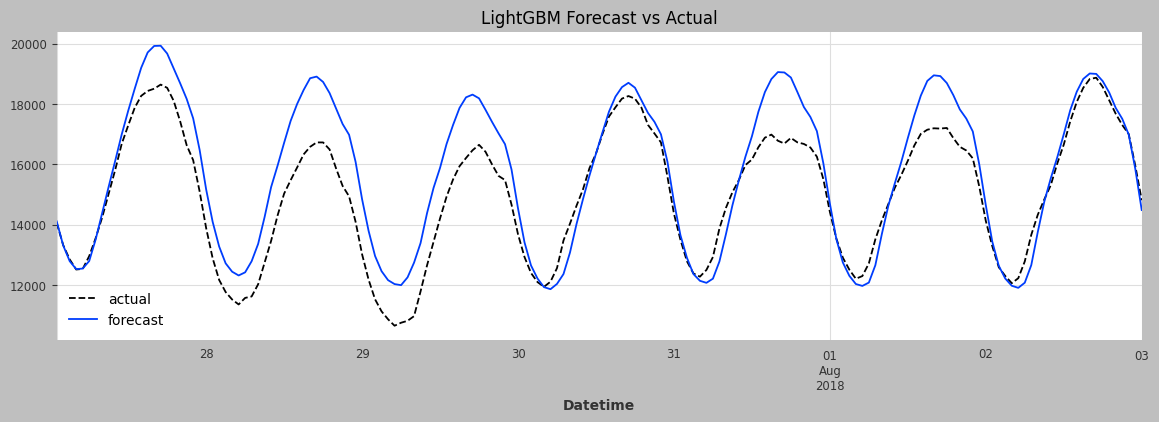

In [40]:
y_test.plot(label='actual', style='--')
y_pred.plot(label='forecast')
plt.title("LightGBM Forecast vs Actual")
plt.legend()
plt.show()

### LGBMRegressor with FT

In [41]:
from statsmodels.tsa.deterministic import Fourier

day = 24
week=168
semi_annual = 4332

fourier_daily  = Fourier(period=day, order=4)
fourier_weekly = Fourier(period=week, order=6) 
fourier_semi_annual = Fourier(period=semi_annual, order=8)  


idx = df.index 
X_list = [
    fourier_daily.in_sample(idx),
    fourier_weekly.in_sample(idx),
    fourier_semi_annual.in_sample(idx)
]

X = pd.concat(X_list, axis=1)


X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

In [42]:
print("Shape of y_train:", y_train.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_test:", X_test.shape)

Shape of y_train: (121128,)
Shape of X_train: (121128, 36)
Shape of y_test: (168,)
Shape of X_test: (168, 36)


In [43]:
# Create LightGBM regressor instance
ft_lgbm_regressor = LGBMRegressor(random_state=42)
# window_length is the number of past observations used to forecast
ft_forecaster = make_reduction(ft_lgbm_regressor, 
                               strategy="recursive", 
                               window_length=168)

In [44]:
ft_forecaster.fit(y=y_train, X=X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.046219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585080
[LightGBM] [Info] Number of data points in the train set: 120960, number of used features: 6216
[LightGBM] [Info] Start training from score 15502.140121


RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(random_state=42),
                                     window_length=168)

In [45]:
ft_y_pred = ft_forecaster.predict(fh=fh, X=X_test)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWar

In [46]:
ft_lgbm_mae = mae(y_true=y_test, y_pred=ft_y_pred)
ft_lgbm_rmse = np.sqrt(mse(y_true=y_test, y_pred=ft_y_pred))

print("LightGBM with Fourier Terms MAE:", ft_lgbm_mae)
print("LightGBM with Fourier Terms RMSE:", ft_lgbm_rmse)

LightGBM with Fourier Terms MAE: 539.5367880246538
LightGBM with Fourier Terms RMSE: 759.8291763728683


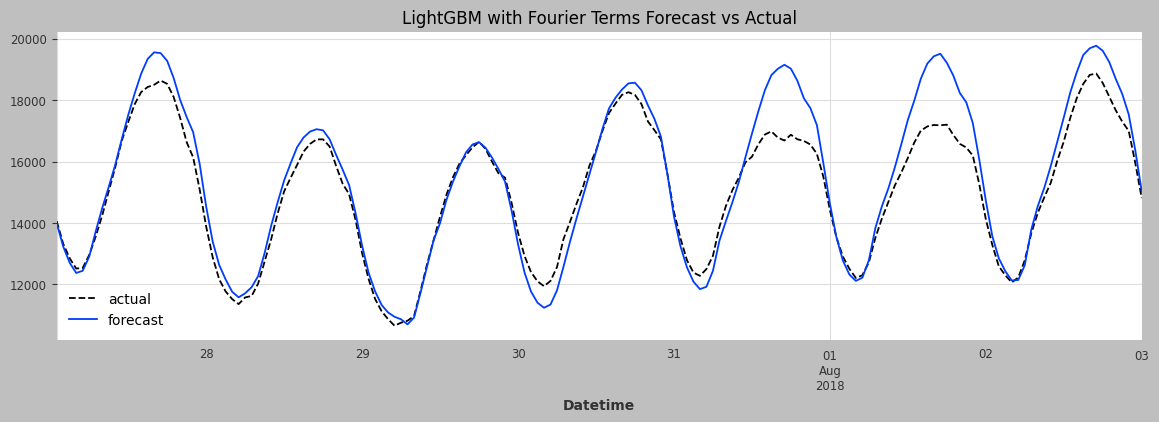

In [47]:
y_test.plot(label='actual', style='--')
ft_y_pred.plot(label='forecast')
plt.title("LightGBM with Fourier Terms Forecast vs Actual")
plt.legend()
plt.show()

## How it works

In [ ]:
# LightGBM regressor with recursive strategy
ft_mo_lgbm_regressor = LGBMRegressor(random_state=42)
# window_length is the number of past observations used to forecast
ft_mo_forecaster = make_reduction(ft_mo_lgbm_regressor, 
                               strategy="recursive", 
                               window_length=168)
ft_mo_forecaster.fit(y=y_train, X=X_train)

In [ ]:
# LightGBM regressor with multioutput strategy
from sklearn.multioutput import MultiOutputRegressor
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Create LightGBM regressor instance
ft_mo_lgbm_regressor = LGBMRegressor(random_state=42)
# window_length is the number of past observations used to forecast
ft_mo_forecaster = make_reduction(MultiOutputRegressor(ft_mo_lgbm_regressor), 
                               strategy="multioutput", 
                               window_length=168)
ft_mo_forecaster.fit(y=y_train, X=X_train, fh=fh)

In [ ]:
# Example using AutoEnsembleForecaster
from sktime.forecasting.compose import AutoEnsembleForecaster
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1. Create a list of forecasters 
tree_based_forecasters = [
    ("lgbm", make_reduction(
        LGBMRegressor(n_estimators=10, random_state=42), 
        strategy="recursive", 
        window_length=168
    )),
    
    ("rf", make_reduction(
        RandomForestRegressor(n_estimators=10, random_state=42), 
        strategy="recursive", 
        window_length=168
    )),

    ("gb", make_reduction(
        GradientBoostingRegressor(n_estimators=10, random_state=42), 
        strategy="recursive", 
        window_length=168
    ))
]

# 2. Instantiate the AutoEnsembleForecaster with your custom list
ensemble_forecaster = AutoEnsembleForecaster(forecasters=tree_based_forecasters)

# 3. Fit the ensemble, passing the Fourier terms in `X`
print("Fitting the tree-based ensemble...")
ensemble_forecaster.fit(y=y_train, X=X_train, fh=fh)

# 4. Predict using the features for the test set
y_pred_ensemble = ensemble_forecaster.predict(X=X_test)

# 5. Evaluate the results
ensemble_mae = mae(y_test, y_pred_ensemble)
ensemble_rmse = np.sqrt(mse(y_test, y_pred_ensemble))

print(f"\nTree-Based Ensemble with Fourier Terms MAE: {ensemble_mae}")
print(f"Tree-Based Ensemble with Fourier Terms RMSE: {ensemble_rmse}")

## There's more

In [48]:
import tsfel

In [49]:
cfg = tsfel.get_features_by_domain()
cfg.keys()

dict_keys(['spectral', 'statistical', 'temporal', 'fractal'])

In [50]:
X = tsfel.time_series_features_extractor(cfg, df['y'])
print("TSFEL Features shape:", X.shape)


/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/1493150931.py:1: UserWarning: Using default sampling frequency set in configuration file.
  X = tsfel.time_series_features_extractor(cfg, df['y'])
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/tsfel/feature_extraction/calc_features.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(timeseries[0], pd.DataFrame):


TSFEL Features shape: (1, 156)


In [51]:
print(cfg['spectral'].keys())

dict_keys(['Spectrogram mean coefficient', 'Fundamental frequency', 'Human range energy', 'LPCC', 'MFCC', 'Max power spectrum', 'Maximum frequency', 'Median frequency', 'Power bandwidth', 'Spectral centroid', 'Spectral decrease', 'Spectral distance', 'Spectral entropy', 'Spectral kurtosis', 'Spectral positive turning points', 'Spectral roll-off', 'Spectral roll-on', 'Spectral skewness', 'Spectral slope', 'Spectral spread', 'Spectral variation', 'Wavelet absolute mean', 'Wavelet energy', 'Wavelet entropy', 'Wavelet standard deviation', 'Wavelet variance'])


In [52]:
cfg = tsfel.get_features_by_domain('spectral')
X = tsfel.time_series_features_extractor(cfg, df['y'])
print("TSFEL Features shape:", X.shape)


/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/1913833018.py:2: UserWarning: Using default sampling frequency set in configuration file.
  X = tsfel.time_series_features_extractor(cfg, df['y'])
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/tsfel/feature_extraction/calc_features.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(timeseries[0], pd.DataFrame):


TSFEL Features shape: (1, 111)


In [53]:
X.columns

Index(['0_Fundamental frequency', '0_Human range energy', '0_LPCC_0',
       '0_LPCC_1', '0_LPCC_10', '0_LPCC_11', '0_LPCC_2', '0_LPCC_3',
       '0_LPCC_4', '0_LPCC_5',
       ...
       '0_Wavelet standard deviation_8.33Hz', '0_Wavelet variance_12.5Hz',
       '0_Wavelet variance_2.78Hz', '0_Wavelet variance_25.0Hz',
       '0_Wavelet variance_3.12Hz', '0_Wavelet variance_3.57Hz',
       '0_Wavelet variance_4.17Hz', '0_Wavelet variance_5.0Hz',
       '0_Wavelet variance_6.25Hz', '0_Wavelet variance_8.33Hz'],
      dtype='object', length=111)

In [54]:
cfg['spectral']

{'Spectrogram mean coefficient': {'complexity': 'constant',
  'description': 'Calculates the average value for each frequency in the spectrogram over the entire duration of the signal.',
  'function': 'tsfel.spectrogram_mean_coeff',
  'parameters': {'fs': 100, 'bins': 32},
  'n_features': 'bins',
  'use': 'yes'},
 'Fundamental frequency': {'complexity': 'log',
  'description': 'Computes the fundamental frequency.',
  'function': 'tsfel.fundamental_frequency',
  'parameters': {'fs': 100},
  'n_features': 1,
  'use': 'yes'},
 'Human range energy': {'complexity': 'log',
  'description': 'Computes the human range energy ratio given by the ratio between the energy in frequency 0.6-2.5Hz and the whole energy band.',
  'function': 'tsfel.human_range_energy',
  'parameters': {'fs': 100},
  'n_features': 1,
  'use': 'yes',
  'tag': 'inertial'},
 'LPCC': {'complexity': 'log',
  'description': 'Computes the linear prediction cepstral coefficients.',
  'function': 'tsfel.lpcc',
  'parameters': {'n

In [55]:
spectral_cfg = tsfel.get_features_by_domain('spectral')

selected_keys = [
    'Spectrogram mean coefficient',
    'Fundamental frequency',
    'Max power spectrum',
    'Maximum frequency',
    'Spectral centroid',
    'Spectral entropy',
    'Spectral roll-off',
    'Spectral slope',
    'Wavelet energy',
    'Wavelet entropy'
]

# Filter the config dictionary
filtered_features = {k: spectral_cfg['spectral'].get(k) for k in selected_keys if k in spectral_cfg['spectral']}

custom_cfg = {'spectral': filtered_features}


In [56]:
# custom_cfg

In [ ]:
from joblib import Parallel, delayed

window_length = 24  

# Sliding step 
step = 6

def extract_features(i):
    segment = df['y'].iloc[i - window_length:i].values
    features = tsfel.time_series_features_extractor(custom_cfg, segment).values.flatten()
    return features

# Generate indices with sliding step to reduce total computations
indices = range(window_length, len(df), step)

# Parallelize feature extraction utilizing all CPU cores
features_list = Parallel(n_jobs=-1)(delayed(extract_features)(i) for i in indices)

# Convert to numpy array for downstream modeling
X = np.array(features_list)


/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |█████---------------------------------------------| 10% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████���██████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████��███████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████----------------------------------------| 20% Completete
Progress: |█████████████████���████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completee
Progress: |█████████████████████████-------------------------| 50% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |���█████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████---------------| 70% Completeee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |���█████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████----------------------------------------| 20% Completeete
Progress: |█████---------------------------------------------| 10% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████████████��█████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |████████████████████████████████████████----------| 80% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████���███| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████████��██████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████-----| 90% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complet

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████���██████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████��███████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████��██████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████----------------------------------------| 20% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

�███████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████��███████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████████���█████████| 100% Complete
Progress: |███████████████████████████████████

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████��█████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████���████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████��█████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████���██████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█��████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████████████████████████████---------------| 70% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████���███████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complet

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████��████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completee
Progress: |████████████████████------------------------------| 40% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████-----| 90% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████���██████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████-------------------------| 50% Completete
Progress: |████████████████████████████████████████████████���█| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████��██████████████████| 100% Complete
Progress: |█████████��████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█��████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete

Progress: |█████████████████████████████████████████████-----| 90% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████---------------| 70% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████���██████████████████████| 100% Complete

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████--------------------| 60% Completee
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████���█████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complet

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████���█████████---------------| 70% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████-----| 90% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████��███████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████████████████████���██████████████████████| 100% Complete
Progress: |█████████████████████████-------------------------| 50% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████████████████████���██████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████���██████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████---------------------------------------------| 10% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████���████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████████████████████████��████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████���█████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████-------------------------| 50% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████��███████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████████████���██████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████��███████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████-----------------------------------| 30% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████████████���██████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████---------------------------------------------| 10% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████---------------------------------------------| 10% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████��████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████��███| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████��█████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |████████████████████████████��█████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████���█████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████���███████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████-----------------------------------| 30% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████���███████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████---------------------------------------------| 10% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████████���██████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████████████████████████████████���████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████���█████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████���███████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% 

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |��█████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

█████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████████----------| 80% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |��█████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████��██████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████��████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█��████████████████████████████████████████████████| 100% Complete
Progress: |█���████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████----------------------------------------| 20% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████��████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████-------------------------| 50% Completee
Progress: |█████████████████████████��████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complet

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████��█████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████-----| 90% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |█████████████████████████████████████████████-----| 90% Completete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██���███████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████���█████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████-----| 90% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |███████���██████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████████████████████████████████████��████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██��███████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |████████████████████████████��█████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█���████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████-----------------------------------| 30% Completee
Progress: |██████████████████████████████████���███████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% C

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████���████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |█████████████████████████████████���████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Com

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████��█████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████------------------------------| 40% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████████████████���█| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█��████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████-----------------------------------| 30% Completeee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████���██████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Compl

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████��████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

Progress: |█████████████████████████-------------------------| 50% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |███████████████████████████��██████████████████████| 100% Complete
Progress: |███████████████████████████████████---------------| 70% Completee
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████���███████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████��██████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████████████████████��█████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comple

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████████████████████████���████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Comp

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████████-------------------------| 50% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████���██████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████████████---------------| 70% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |█████████████████████���████████████████████████████| 100% Co

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

██████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████���██████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Completee
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |████████████████████████████��█████████████████████| 100% Complete
Progress: |██████████████████████████████████████████████████| 100% Complete
Progress: |███████████████████████████

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698/2019919932.py:12: UserWarning: Using default sampling frequency set in configuration file.
/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_36698

In [59]:
feature_index = df.index[window_length::step]
X_df = pd.DataFrame(X, index=feature_index)
X_df.shape

(20212, 30)

In [3]:
121296/6

20216.0

In [60]:
y_aligned = df['y'].loc[feature_index]

In [69]:
y_aligned.shape

(20212,)

In [61]:
y_train, y_test = temporal_train_test_split(y_aligned, test_size=168)
X_train, X_test = X_df.loc[y_train.index], X_df.loc[y_test.index]


In [62]:
y_train.shape

(20044,)

In [63]:
X_train.shape

(20044, 30)

In [64]:
# Set up forecasting with exogenous TSFEL features
forecaster = make_reduction(
    LGBMRegressor(random_state=42), 
    strategy="recursive", 
    window_length=window_length
)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171888
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 744
[LightGBM] [Info] Start training from score 15505.027772


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWar

In [65]:
lgbm_mae = mae(y_true=y_test, y_pred=y_pred)
lgbm_rmse = np.sqrt(mse(y_true=y_test, y_pred=y_pred))
print("LightGBM + TSFEL MAE:", lgbm_mae)
print("LightGBM + TSFEL RMSE:", lgbm_rmse)

LightGBM + TSFEL MAE: 673.4105428147262
LightGBM + TSFEL RMSE: 896.0030175330448


In [68]:
y_test.shape
y_pred.shape

(168,)

# Recipe 4: StemGNN

In [72]:
from neuralforecast import NeuralForecast
from neuralforecast.models import StemGNN
from neuralforecast.losses.pytorch import MAE

2025-09-05 15:57:55,937	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-05 15:57:56,115	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [73]:
df_sf = df.copy()
df_sf.reset_index(inplace=True)
df_sf.rename(columns={'Datetime': 'ds'}, inplace=True)
df_sf['unique_id'] = 'AEP_hourly'  # Adding a unique ID for StatsForecast

print(df_sf.head())

                   ds        y   unique_id
0 2004-10-01 01:00:00  12379.0  AEP_hourly
1 2004-10-01 02:00:00  11935.0  AEP_hourly
2 2004-10-01 03:00:00  11692.0  AEP_hourly
3 2004-10-01 04:00:00  11597.0  AEP_hourly
4 2004-10-01 05:00:00  11681.0  AEP_hourly


In [ ]:
week = 168
train_sf = df_sf.iloc[:-week]
test_sf = df_sf.iloc[-week:]

print(f"Train length: {len(train_sf)}")
print(f"Test length: {len(test_sf)}")

Train length: 121128
Test length: 168


In [94]:
model = StemGNN(
    h=168,
    input_size=168*2,
    n_series=1,            # only one unique series
    scaler_type='standard',
    max_steps=500,
    early_stop_patience_steps=-1,
    val_check_steps=10,
    learning_rate=0.001,
    loss=MAE(),
    valid_loss=MAE(),
    batch_size=32
)

Seed set to 1


In [95]:
fcst = NeuralForecast(models=[model], freq='H')  # Hourly frequency


In [96]:
fcst.fit(df=train_sf, val_size=week)  # Use last 168 points as validation


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 1.0 K  | train
5 | stock_block  | ModuleList    | 825 M  | train
6 | fc           | Sequential    | 169 K  | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 2      | n/a  
-------------------------------------------------------
825 M     Trainable params
0         Non-trainable params
825 M     Total params
3,301.073 Total estimated model params size (MB)
61        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, v_num=8, train_loss_step=0.929, train_loss_epoch=0.929, valid_loss=2.23e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, v_num=8, train_loss_step=0.929, train_loss_epoch=0.929, valid_loss=2.23e+3]


In [97]:
forecasts = fcst.predict()

# Inspect the first few predictions
print(forecasts.head())

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
    unique_id                  ds       StemGNN
0  AEP_hourly 2018-07-27 01:00:00  15950.449219
1  AEP_hourly 2018-07-27 02:00:00  15933.606445
2  AEP_hourly 2018-07-27 03:00:00  15939.565430
3  AEP_hourly 2018-07-27 04:00:00  15928.162109
4  AEP_hourly 2018-07-27 05:00:00  15958.204102


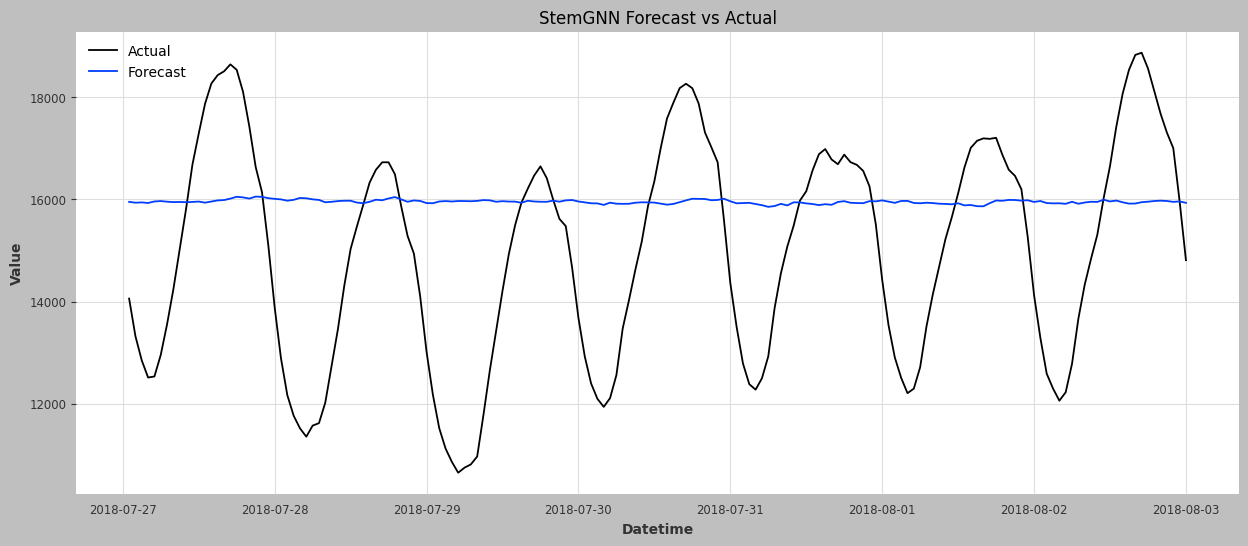

In [98]:
# Optionally, plot actual vs. forecast for visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(test_sf['ds'], test_sf['y'], label='Actual')
plt.plot(test_sf['ds'], forecasts['StemGNN'], label='Forecast')
plt.title('StemGNN Forecast vs Actual')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.show()

In [106]:
test_sf.shape

(168, 3)

In [107]:
forecasts.shape

(168, 3)

In [104]:
forecasts

unique_id                  ds       StemGNN
0    AEP_hourly 2018-07-27 01:00:00  15950.449219
1    AEP_hourly 2018-07-27 02:00:00  15933.606445
2    AEP_hourly 2018-07-27 03:00:00  15939.565430
3    AEP_hourly 2018-07-27 04:00:00  15928.162109
4    AEP_hourly 2018-07-27 05:00:00  15958.204102
..          ...                 ...           ...
163  AEP_hourly 2018-08-02 20:00:00  15973.462891
164  AEP_hourly 2018-08-02 21:00:00  15967.235352
165  AEP_hourly 2018-08-02 22:00:00  15950.101562
166  AEP_hourly 2018-08-02 23:00:00  15958.545898
167  AEP_hourly 2018-08-03 00:00:00  15931.179688

[168 rows x 3 columns]

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming test_sf['y'] are actual values and forecasts['StemGNN'] are predictions
y_true = test_sf['y'].values
y_pred = forecasts['StemGNN'].values

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 1922.2818952287946
RMSE: 2365.4496556833797
